# Task 1: quadratic oscillator

$$\mathcal{H} = \frac{p^2}{2} + \frac{q^2}{2} + \frac{s^2}{2} - 1$$

In [1]:
import torch, time, sys
import autograd
import autograd.numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import scipy.integrate
import numpy as nump
solve_ivp = scipy.integrate.solve_ivp

EXPERIMENT_DIR = './experiment-quad-osc'
sys.path.append(EXPERIMENT_DIR)

from data import get_dataset, get_field, get_trajectory, dynamics_fn, hamiltonian_fn# kofmotion, k2_fn
from nn_models import MLP
from hnn import HNN
from utils import L2_loss
sq2=np.sqrt(2.)

plt.rcParams['font.size'] = 16
plt.rcParams['font.family'] = "serif"
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['xtick.direction'] = "in"
plt.rcParams['xtick.bottom'] = True
plt.rcParams['xtick.major.size'] = 5
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['ytick.direction'] = "in"
plt.rcParams['ytick.left'] = True
plt.rcParams['ytick.major.size'] = 5
plt.rcParams['legend.fontsize'] = 18
plt.rcParams['mathtext.fontset'] = "cm"
plt.rcParams["savefig.bbox"] = 'tight'

## Set some notebook constants

In [2]:
DPI = 300
FORMAT = 'pdf'
LINE_SEGMENTS = 10
ARROW_SCALE = 30
ARROW_WIDTH = 6e-3
LINE_WIDTH = 2
RK4 = ''

def get_args():
    return {'input_dim': 3,
         'hidden_dim': 200,
         'learn_rate': 1e-3,
         'nonlinearity': 'tanh',
         'total_steps': 2000,
         'field_type': 'solenoidal',
         'print_every': 200,
         'name': 'quad-osc',
         'gridsize': 10,
         'input_noise': 0.5,
         'seed': 0,
         'save_dir': './{}'.format(EXPERIMENT_DIR),
         'fig_dir': './figures'}

class ObjectView(object):
    def __init__(self, d): self.__dict__ = d

## Inspect the dataset

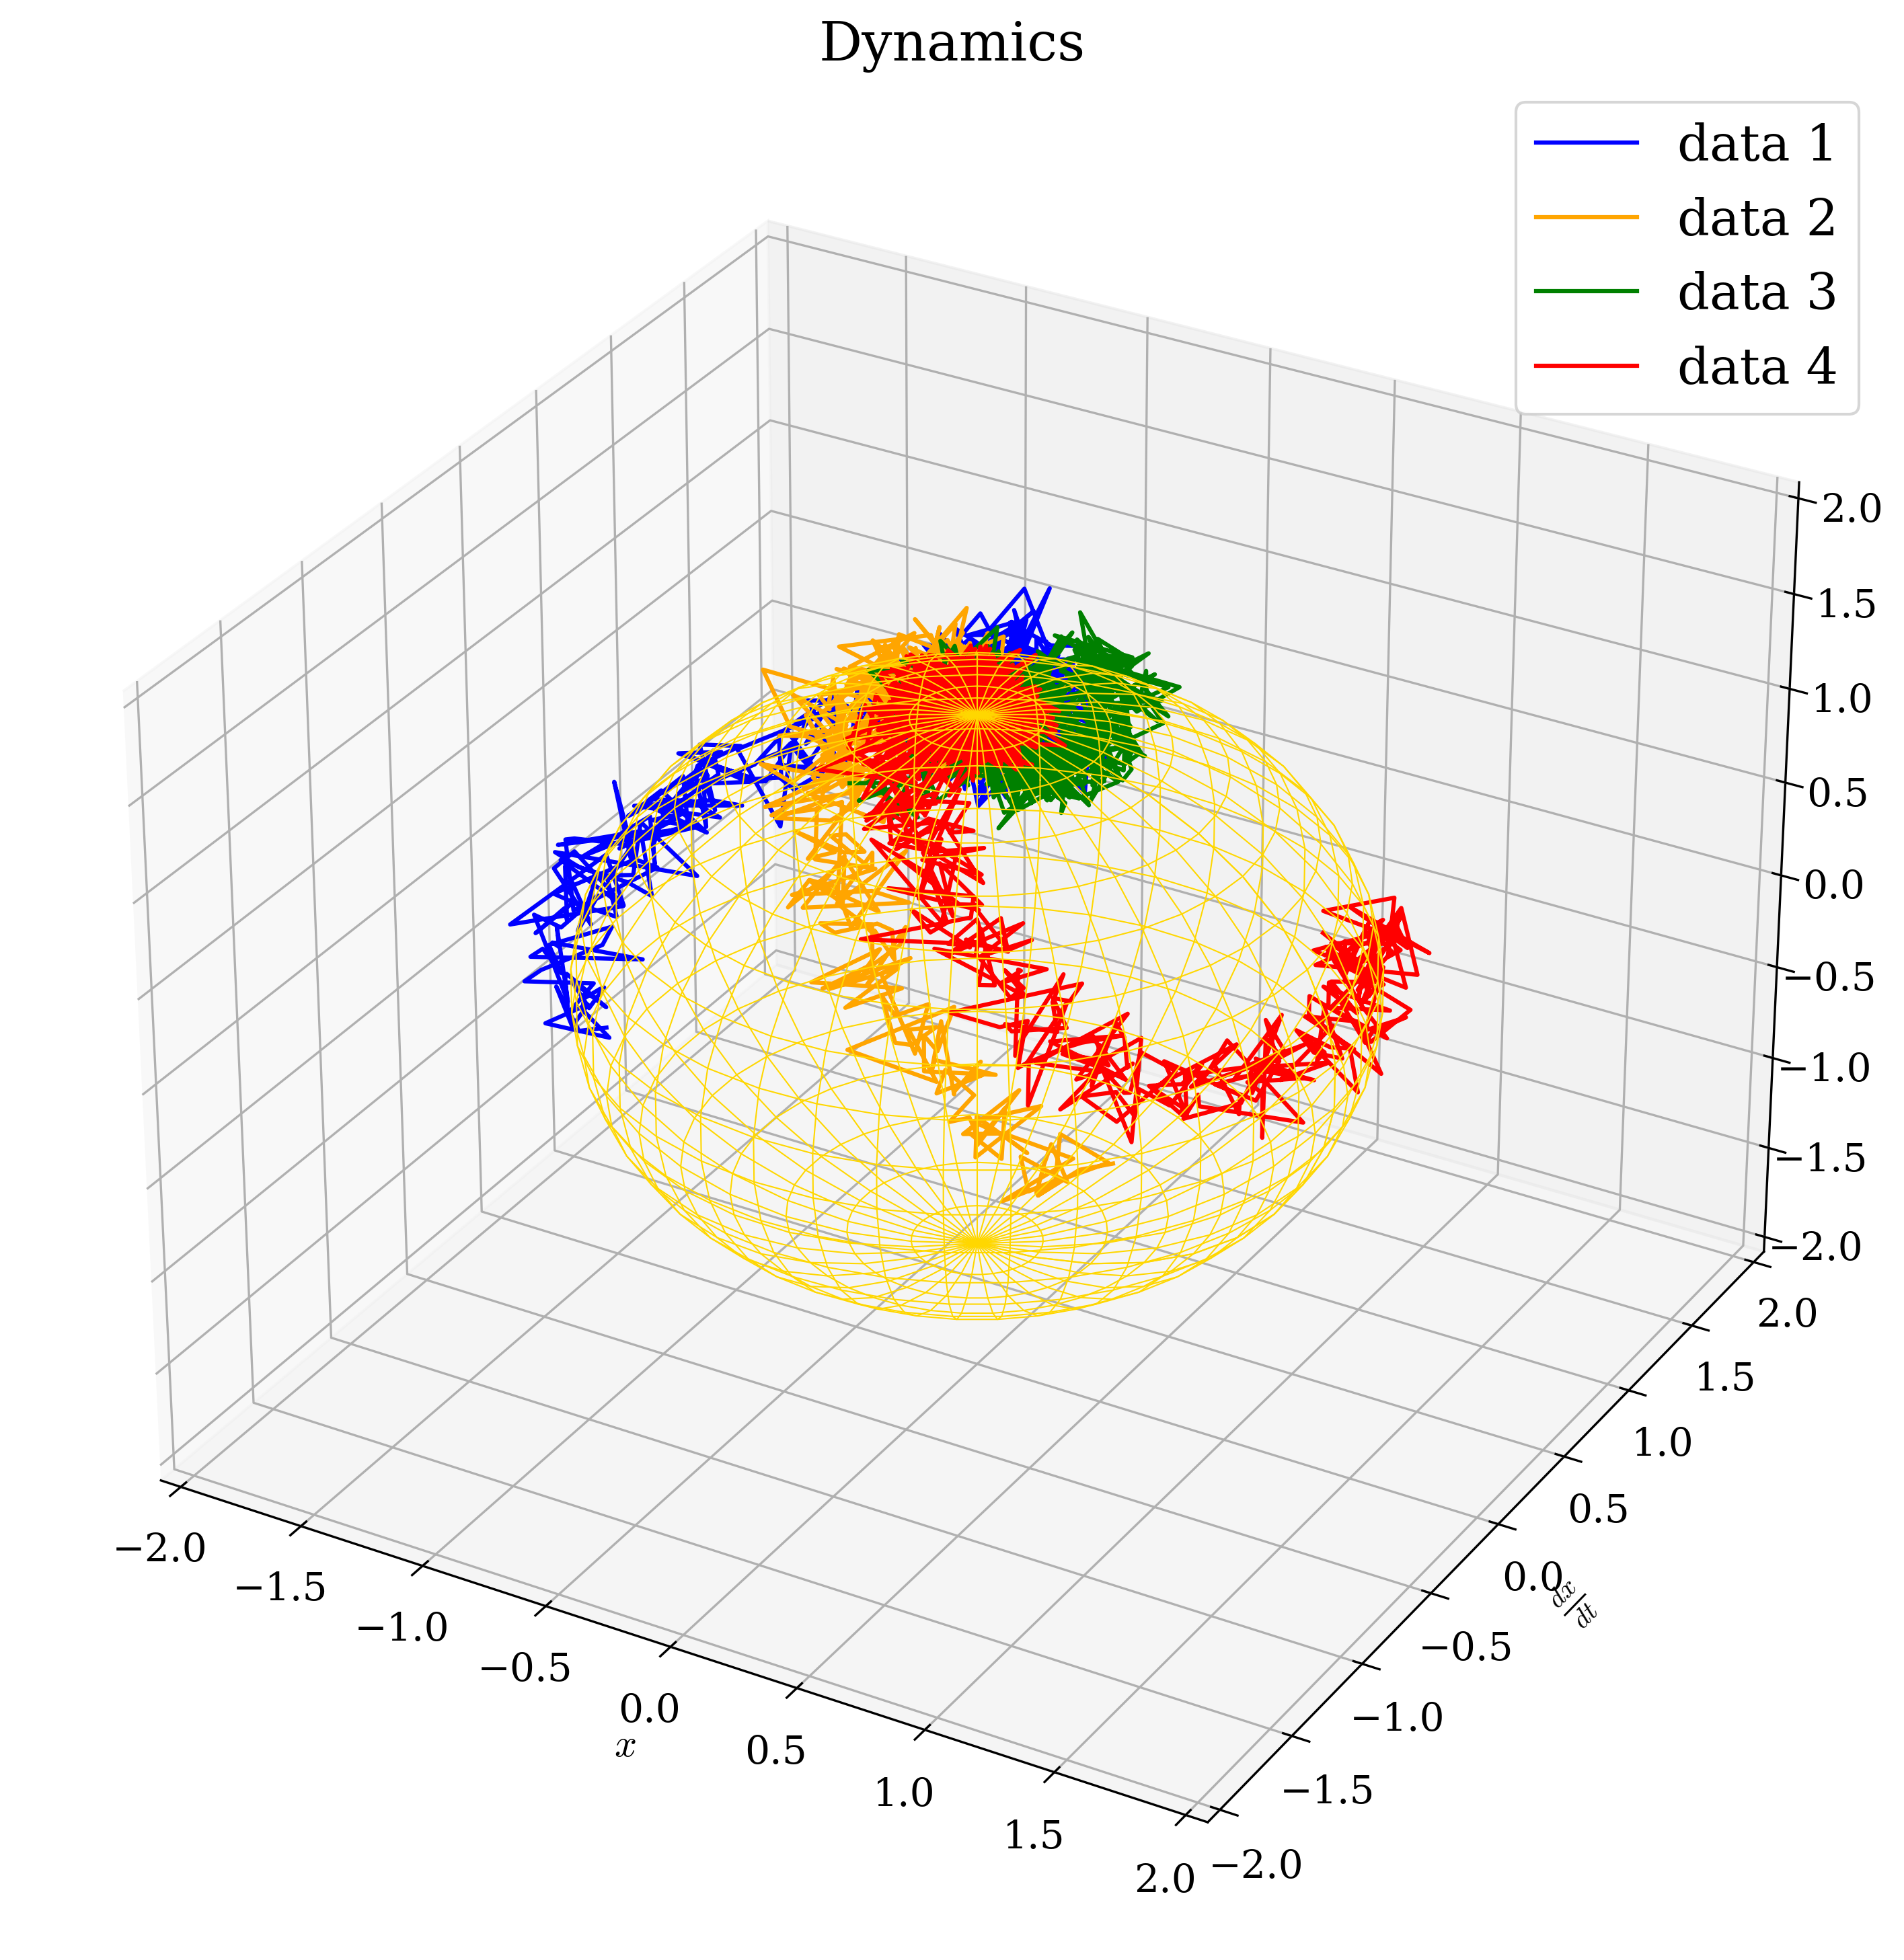

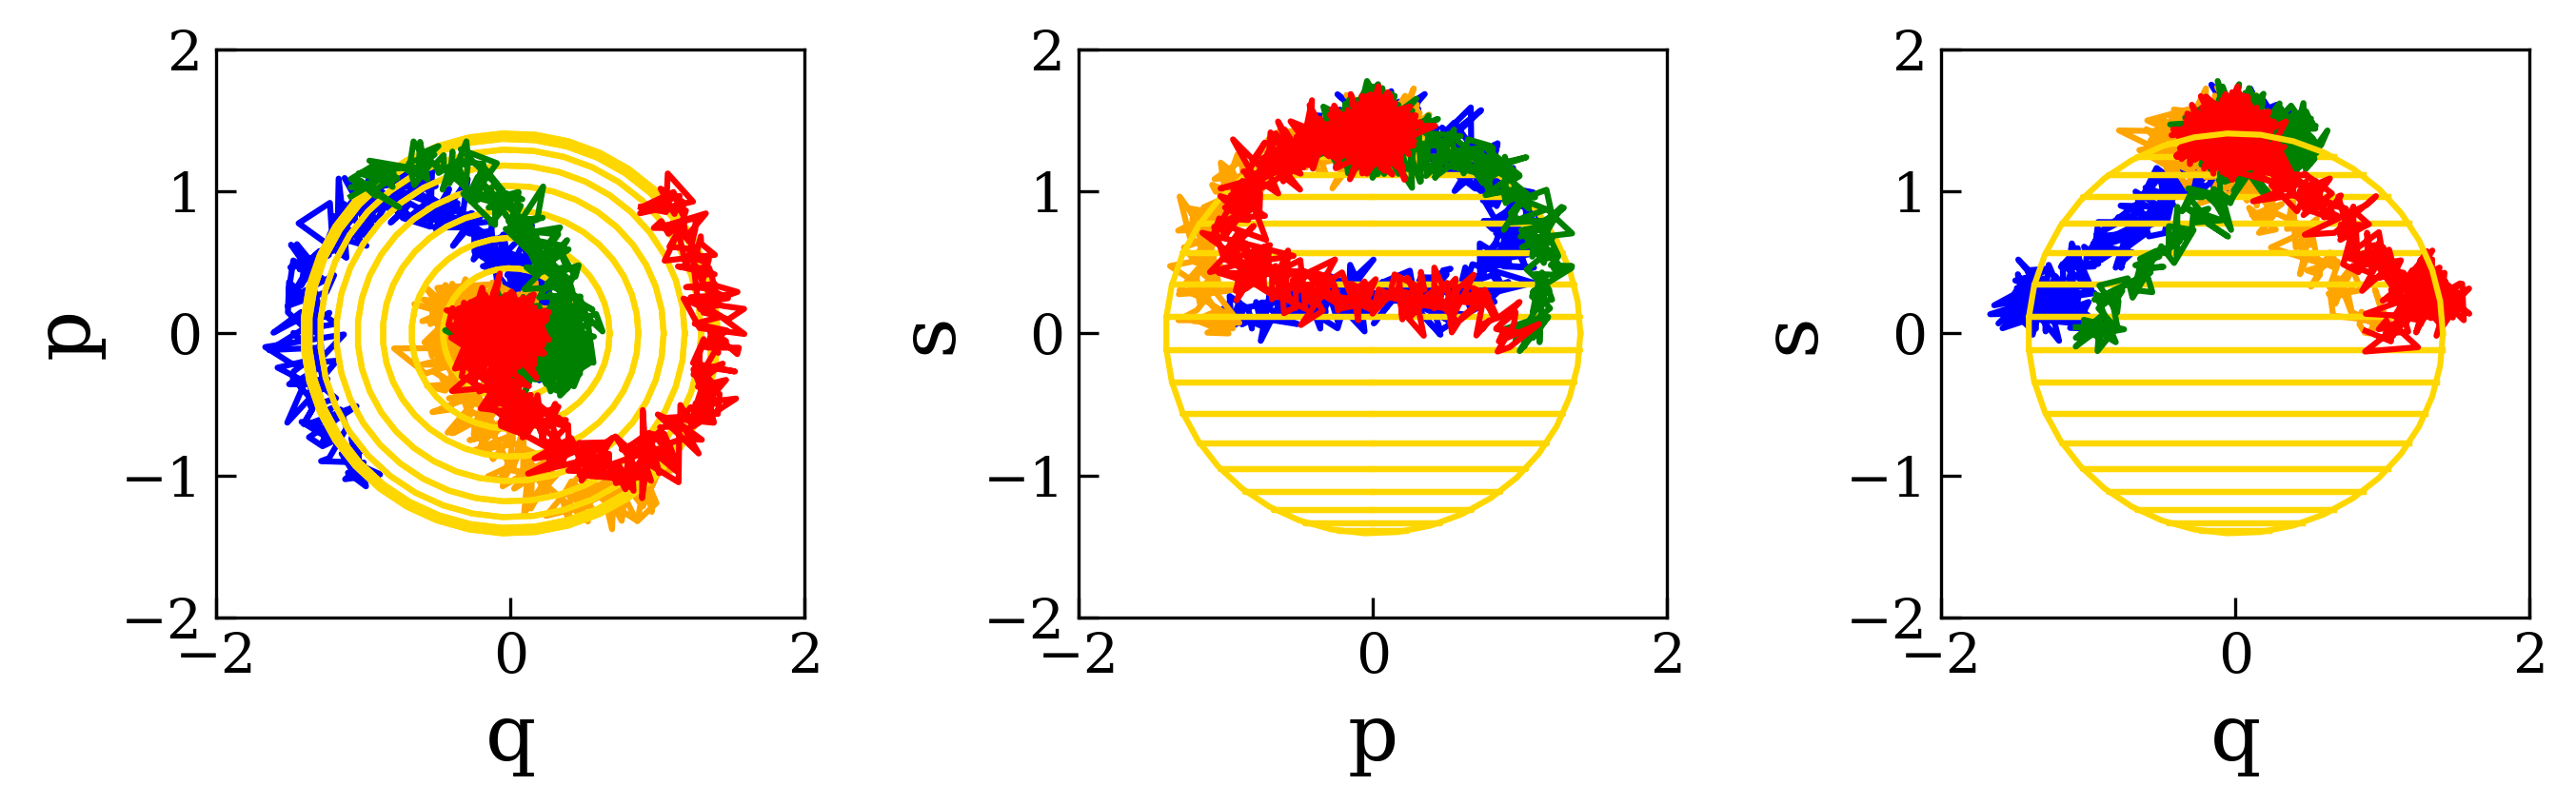

In [30]:
args = ObjectView(get_args())
# np.random.seed(args.seed)
#field = get_field(xmin=-10,xmax=10,ymin=-10,ymax=10,zmin=-2,zmax=2,gridsize=15)
data = get_dataset(samples=20) 
# data of training and testing as a dictionary
# splitted by coordinates {'x'} and {'dx'}
y0=np.array([1.,-1.,0.])
# plot config
fig = plt.figure(figsize=(10, 10), facecolor='white', dpi=DPI)
ax = fig.gca(projection="3d")
x,   y,  z,  dx,  dy, dz, t = get_trajectory(radius=sq2,y0=np.array([-1.,-1.,0]),hamint=False,timescale=100)
x1, y1, z1, dx1, dy1, dz1, t1 = get_trajectory(radius=sq2,y0=np.array([1.,-1.,0]),hamint=False,timescale=100)
x3, y3, z3, _, _, _, _ = get_trajectory(radius=sq2,y0=np.array([-1.,1.,0]),hamint=False,timescale=100)
x4, y4, z4, _, _, _, _ = get_trajectory(radius=sq2,y0=np.array([1.,1.,0]),hamint=False,timescale=100)
# solution given by the numerical integrator and a noise
#plt.scatter(x,z,s=14, label='data')
ax.plot(x,  y, z,linewidth=1.5,label="data 1",color='blue')
ax.plot(x1,y1,z1,linewidth=1.5,label="data 2",color='orange')
ax.plot(x3,y3,z3,linewidth=1.5,label="data 3",color='green')
ax.plot(x4,y4,z4,linewidth=1.5,label="data 4",color='red')
u, v = nump.mgrid[0 : 2 * np.pi : 40j, 0 : np.pi : 20j]
x2 = np.sqrt(2) * np.cos(u) * np.sin(v)
y2 = np.sqrt(2.) * np.sin(u) * np.sin(v)
z2 = np.sqrt(2.) * np.cos(v)
ax.plot_wireframe(x2, y2, z2, color="gold", linewidth=0.5)

ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)
ax.set_zlim(-2, 2)
#plt.quiver(field['x'][:,0], field['x'][:,1], field['dx'][:,0], field['dx'][:,1],
           #map='gray_r', color=(.5,.5,.5))
plt.xlabel("$x$", fontsize=14)
plt.ylabel("$\\frac{dx}{dt}$", rotation=0, fontsize=14)
plt.title("Dynamics")
plt.legend(loc='upper right')
#plt.xlim(-10,10)
#plt.ylim(-10,10)

plt.tight_layout() ; plt.show()
# fig.savefig(fig_dir + '/quadosc-task.png')

fig = plt.figure(figsize=(9.3,3.1), facecolor='white', dpi=DPI)
ax1=fig.add_subplot(1, 3, 1,frameon=True)
ax2=fig.add_subplot(1, 3, 2,frameon=True)
ax3=fig.add_subplot(1, 3, 3,frameon=True)
ax1.plot(x ,y ,'-b')
ax1.plot(x1,y1,color='orange')
ax1.plot(x2,y2,color='gold')
ax1.plot(x3,y3,color='green')
ax1.plot(x4,y4,color='red')
ax1.set_xlabel('q')
ax1.set_ylabel('p',rotation=90)
ax1.set_xlim(-2,2)
ax1.set_ylim(-2,2)
ax2.plot(y , z,'-b')
ax2.plot(y1,z1,color='orange')
ax2.plot(y2,z2,color='gold')
ax2.plot(x2[:,10],y2[:,10],color='gold')
ax2.plot(y3,z3,color='green')
ax2.plot(y4,z4,color='red')
ax2.set_xlabel('p')
ax2.set_ylabel('s',rotation=90)
ax2.set_xlim(-2,2)
ax2.set_ylim(-2,2)
ax3.plot(x , z,'-b')
ax3.plot(x1,z1,color='orange')
ax3.plot(x2,z2,color='gold')
ax3.plot(x3,z3,color='green')
ax3.plot(x4,z4,color='red')
ax3.plot(x2[:,10],y2[:,10],color='gold')
ax3.set_xlabel('q')
ax3.set_ylabel('s',rotation=90)
ax3.set_xlim(-2,2)
ax3.set_ylim(-2,2)
plt.tight_layout(); plt.show()

## Construct models

In [4]:
def get_model(args, baseline,hamint=False):
    output_dim = args.input_dim if baseline else 2
    nn_model = MLP(args.input_dim, args.hidden_dim, output_dim, args.nonlinearity)
    model = HNN(args.input_dim, differentiable_model=nn_model,
              field_type=args.field_type, baseline=baseline)
    
    model_name = 'baseline' if baseline else 'hnn'
    model_name = 'hamint-' + model_name if hamint else model_name
    path = "{}/quad-osc{}-{}.tar".format(args.save_dir, RK4, model_name)
    model.load_state_dict(torch.load(path))
    #print(path)
    return model

## Get vector fields

In [5]:
def get_vector_field(model, **kwargs):
    field = get_field(**kwargs)
    np_mesh_x = field['x']
    
    # run model
    mesh_x = torch.tensor( np_mesh_x, requires_grad=True, dtype=torch.float32)
    mesh_dx = model.time_derivative(mesh_x)
    return mesh_dx.data.numpy()

## Integrate along vector fields

In [6]:
def integrate_model(model, t_span, y0, **kwargs):

    def fun(t, np_x):
        x = torch.tensor( np_x, requires_grad=True, dtype=torch.float32).view(1,3)
        dx = model.time_derivative(x).data.numpy().reshape(-1)
        return dx
    return solve_ivp(fun=fun, t_span=t_span, y0=y0, **kwargs)

## Run analysis

In [7]:
base_model = get_model(args, baseline=True)
hnn_model = get_model(args, baseline=False)
hnn_model_ht = get_model(args, baseline=False, hamint=True)

# get their vector fields
field = get_field(gridsize=args.gridsize)
data = get_dataset()
base_field = get_vector_field(base_model,xmin=-2,xmax=2,ymin=-2,ymax=2,zmin=-2,zmax=2, gridsize=args.gridsize)
hnn_field = get_vector_field(hnn_model,xmin=-2,xmax=2,ymin=-2,ymax=2,zmin=-2,zmax=2, gridsize=args.gridsize)

# integrate along those fields starting from point (1,0)
t_span = [0,15]
y0=np.array([sq2/2,sq2/2,-1.])
#y0*=sq2/(np.linalg.norm(y0,2))
kwargs = {'t_eval': np.linspace(t_span[0], t_span[1], 1000), 'rtol': 1e-12}
base_ivp = integrate_model(base_model, t_span, y0, **kwargs)
hnn_ivp = integrate_model(hnn_model, t_span, y0, **kwargs)
hnn_ivp_ht = integrate_model(hnn_model_ht, t_span, y0, **kwargs)

## Plot results

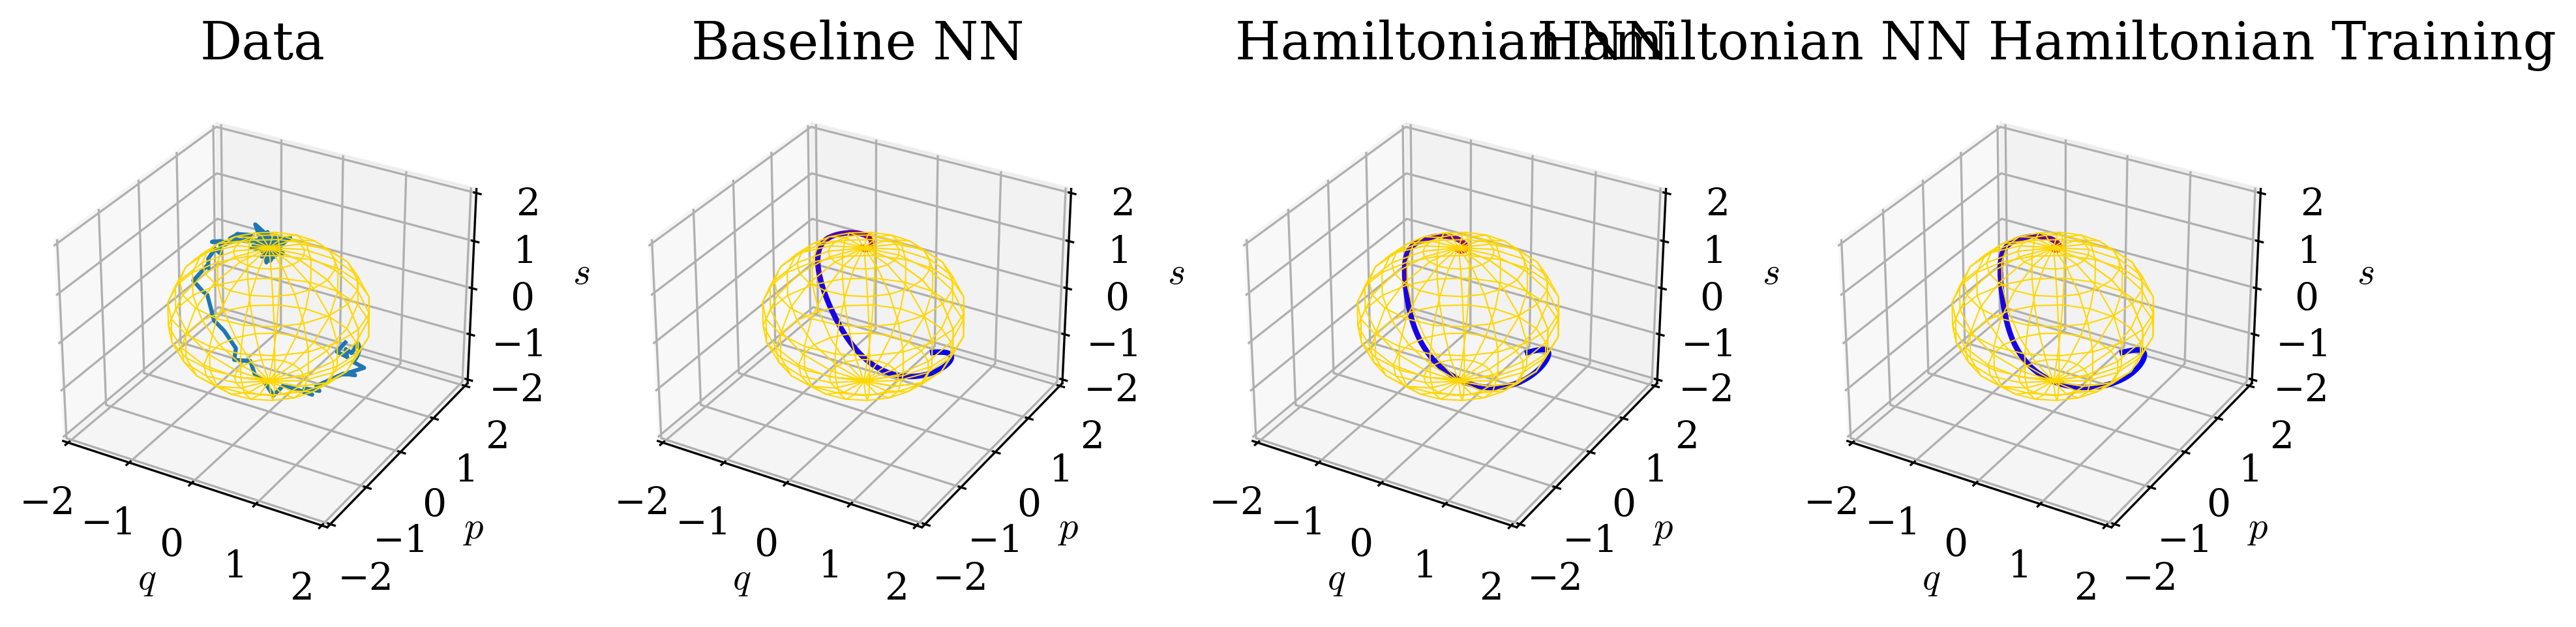

In [8]:
###### PLOT ######
fig = plt.figure(figsize=(12.4, 3.1), facecolor='white', dpi=DPI)
axi1 = fig.add_subplot(1, 4, 1, projection='3d')#, frameon=True)
axi2 = fig.add_subplot(1, 4, 2, projection='3d')#, frameon=True)
axi3 = fig.add_subplot(1, 4, 3, projection='3d')#, frameon=True)
axi4 = fig.add_subplot(1, 4, 4, projection='3d')#, frameon=True)
# plot physical system
#fig.add_subplot(1, 4, 1, frameon=True) 
#plt.xticks([]) ;  plt.yticks([])
#schema = mpimg.imread(EXPERIMENT_DIR + '/mass-spring.png')
#plt.imshow(schema)
#plt.title("Quadratic Oscillator system", pad=10)

# plot dynamics
#fig.add_subplot(1, 4, 2, frameon=True)
x, y, z, dx, dy, dz, t = get_trajectory(radius=sq2, y0=np.array([sq2/2,sq2/2,-1.]),hamint=True)

N = len(x)
point_colors = [(i/N, 0, 1-i/N) for i in range(N)]
axi1.plot(x,y,z, label='data')#, c=point_colors)
axi1.set_xlabel("$q$", fontsize=14)
axi1.set_ylabel("$p$", rotation=0, fontsize=14)
axi1.set_zlabel("$s$", fontsize=14)
axi1.set_xlim(-2,2)
axi1.set_ylim(-2,2)
axi1.set_zlim(-2,2)
axi1.set_title("Data", pad=10)
u, v = nump.mgrid[0 : 2 * np.pi : 20j, 0 : np.pi : 10j]
x2 = np.sqrt(2) * np.cos(u) * np.sin(v)
y2 = np.sqrt(2) * np.sin(u) * np.sin(v)
z2 = np.sqrt(2) * np.cos(v)
axi1.plot_wireframe(x2, y2, z2, color="gold", linewidth=0.5)

# plot baseline
#fig.add_subplot(1, 4, 3, frameon=True)
#plt.quiver(field['x'][:,0], field['x'][:,1], base_field[:,0], base_field[:,1],
#        cmap='gray_r', scale=ARROW_SCALE, width=ARROW_WIDTH, color=(.5,.5,.5))

for i, l in enumerate(np.split(base_ivp['y'].T, LINE_SEGMENTS)):
    color = (float(i)/LINE_SEGMENTS, 0, 1-float(i)/LINE_SEGMENTS)
    #plt.plot(l[:,0],l[:,1],color=color, linewidth=LINE_WIDTH)
    axi2.plot(l[:,0],l[:,1],l[:,2],color=color,linewidth=LINE_WIDTH)
    
axi2.set_xlabel("$q$", fontsize=14)
axi2.set_ylabel("$p$", rotation=0, fontsize=14)
axi2.set_zlabel("$s$", fontsize=14)
axi2.set_xlim(-2,2)
axi2.set_ylim(-2,2)
axi2.set_zlim(-2,2)
axi2.set_title("Baseline NN", pad=10)
axi2.plot_wireframe(x2, y2, z2, color="gold", linewidth=0.5)


# plot HNN
#fig.add_subplot(1, 4, 4, frameon=True)
#plt.quiver(field['x'][:,0], field['x'][:,1], hnn_field[:,0], hnn_field[:,1],
#        cmap='gray_r', scale=ARROW_SCALE, width=ARROW_WIDTH, color=(.5,.5,.5))

for i, l in enumerate(np.split(hnn_ivp['y'].T, LINE_SEGMENTS)):
    color = (float(i)/LINE_SEGMENTS, 0, 1-float(i)/LINE_SEGMENTS)
    #plt.plot(l[:,0],l[:,1],color=color, linewidth=LINE_WIDTH)
    axi3.plot(l[:,0],l[:,1],l[:,2],color=color,linewidth=LINE_WIDTH)
    
axi3.set_xlabel("$q$", fontsize=14)
axi3.set_ylabel("$p$", rotation=0, fontsize=14)
axi3.set_zlabel("$s$", fontsize=14)
axi3.set_xlim(-2,2)
axi3.set_ylim(-2,2)
axi3.set_zlim(-2,2)
axi3.set_title("Hamiltonian NN", pad=10)
axi3.plot_wireframe(x2, y2, z2, color="gold", linewidth=0.5)

for i, l in enumerate(np.split(hnn_ivp_ht['y'].T, LINE_SEGMENTS)):
    color = (float(i)/LINE_SEGMENTS, 0, 1-float(i)/LINE_SEGMENTS)
    #plt.plot(l[:,0],l[:,1],color=color, linewidth=LINE_WIDTH)
    axi4.plot(l[:,0],l[:,1],l[:,2],color=color,linewidth=LINE_WIDTH)
    
axi4.set_xlabel("$q$", fontsize=14)
axi4.set_ylabel("$p$", rotation=0, fontsize=14)
axi4.set_zlabel("$s$", fontsize=14)
axi4.set_xlim(-2,2)
axi4.set_ylim(-2,2)
axi4.set_zlim(-2,2)
axi4.set_title("Hamiltonian NN Hamiltonian Training", pad=10)
axi4.plot_wireframe(x2, y2, z2, color="gold", linewidth=0.5)


plt.tight_layout() ; plt.show()
fig.savefig('{}/quad-osc-traj{}.{}'.format(args.fig_dir, RK4, FORMAT))

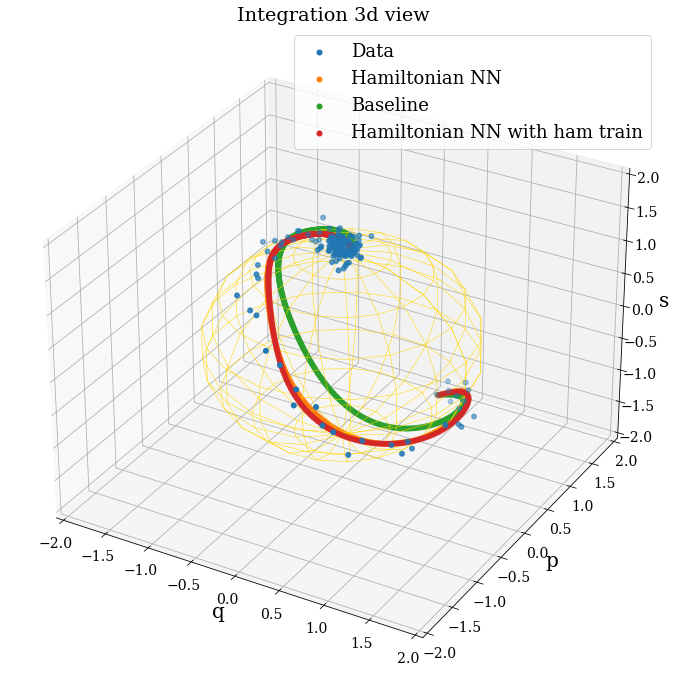

In [9]:
fig = plt.figure(figsize=(12, 12))
ax = fig.gca(projection="3d")
ax.scatter(x,
        y,
        z,
        linewidth=1.5,
        label='Data')

ax.scatter(hnn_ivp['y'].T[:,0],
          hnn_ivp['y'].T[:,1],
          hnn_ivp['y'].T[:,2],
          linewidth=1.5,
          label='Hamiltonian NN')

ax.scatter(base_ivp['y'].T[:,0],
          base_ivp['y'].T[:,1],
          base_ivp['y'].T[:,2],
          linewidth=1.5,
          label='Baseline')

ax.scatter(hnn_ivp_ht['y'].T[:,0],
           hnn_ivp_ht['y'].T[:,1],
           hnn_ivp_ht['y'].T[:,2],
           linewidth=1.5,
           label='Hamiltonian NN with ham train')

ax.legend()
ax.set_title('Integration 3d view')
ax.plot_wireframe(x2, y2, z2, color="gold", linewidth=0.5)
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)
ax.set_zlim(-2, 2)
ax.set_xlabel('q'); ax.set_ylabel('p'); ax.set_zlabel('s')
plt.show()

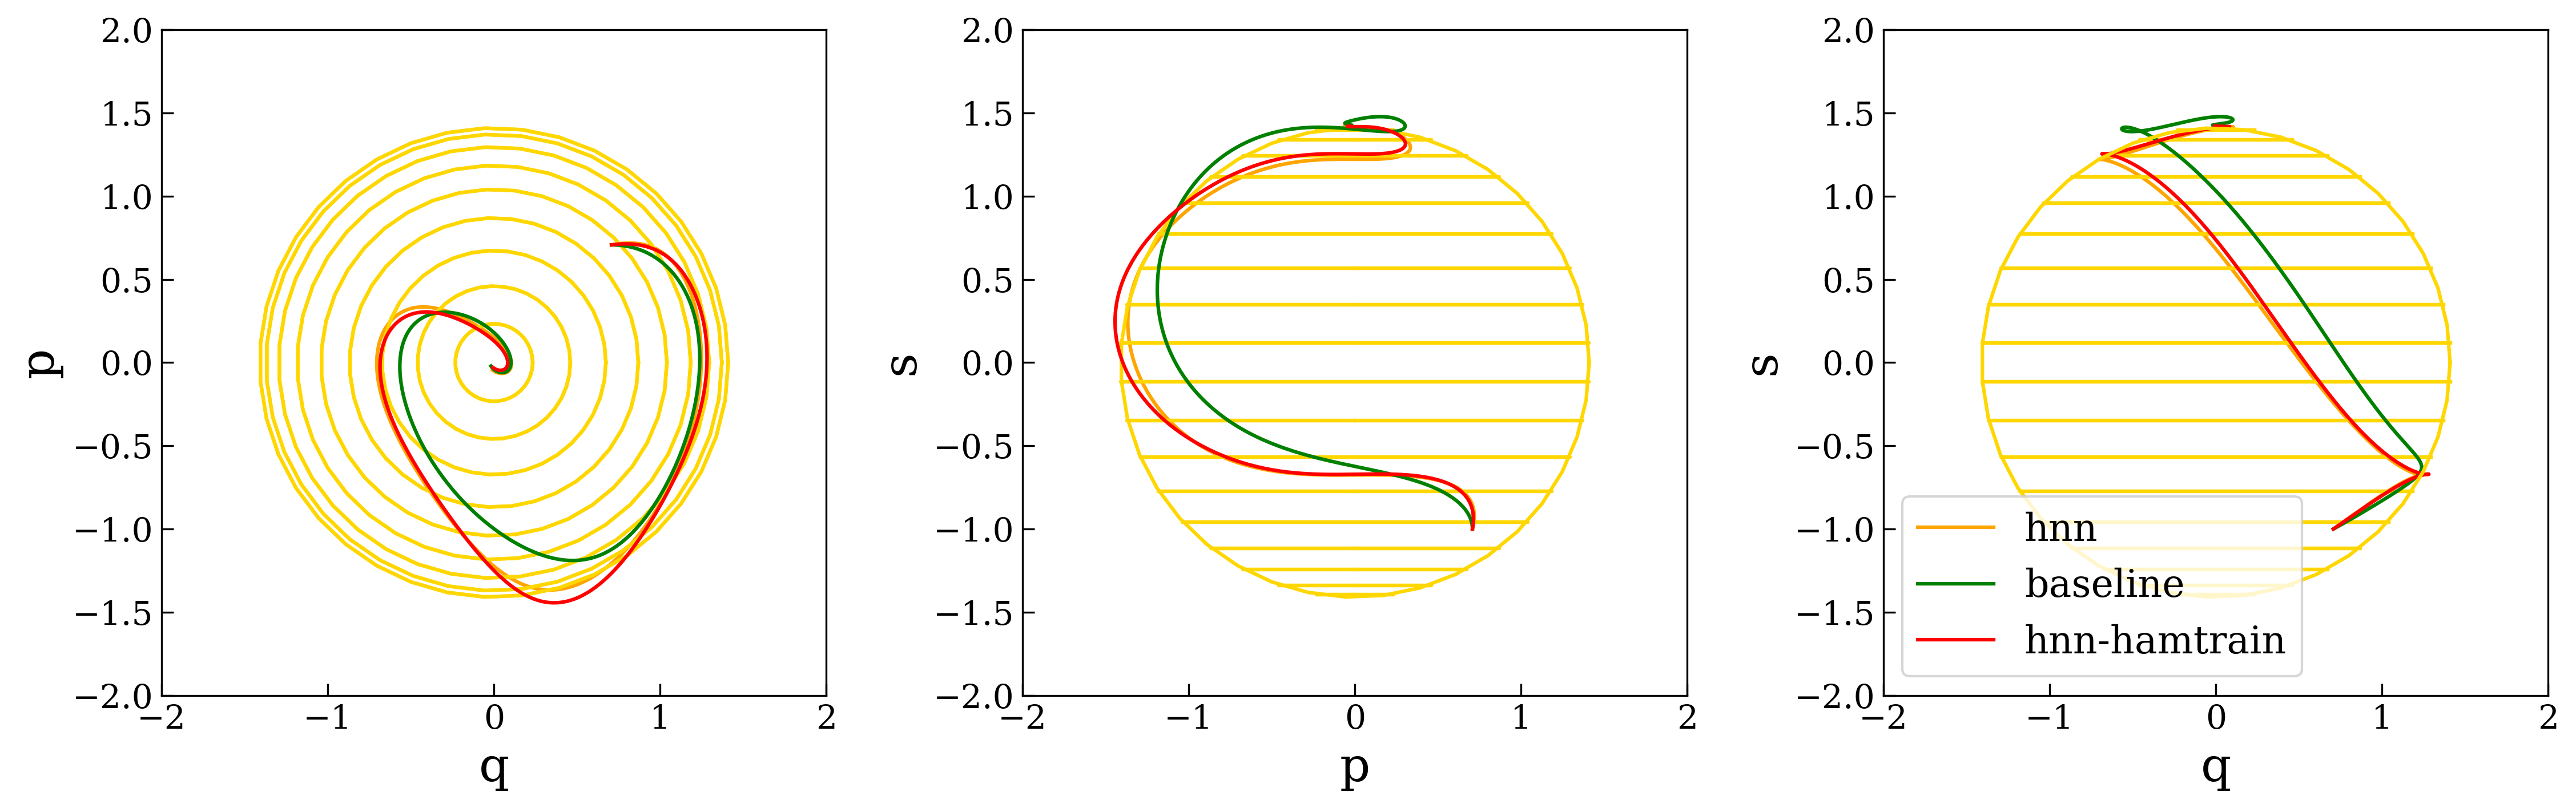

In [26]:
fig = plt.figure(figsize=(15.32,5.0), facecolor='white', dpi=DPI)
u, v = nump.mgrid[0 : 2 * np.pi : 40j, 0 : np.pi : 20j]
x2 = np.sqrt(2) * np.cos(u) * np.sin(v)
y2 = np.sqrt(2.) * np.sin(u) * np.sin(v)
z2 = np.sqrt(2.) * np.cos(v)
ax1=fig.add_subplot(1, 3, 1,frameon=True)
ax2=fig.add_subplot(1, 3, 2,frameon=True)
ax3=fig.add_subplot(1, 3, 3,frameon=True)
#ax1.plot(x,y,color='blue',label='data')
ax1.plot(hnn_ivp['y'].T[:,0],hnn_ivp['y'].T[:,1],color='orange',label='hnn')
ax1.plot(x2,y2,color='gold')
ax1.plot(base_ivp['y'].T[:,0],base_ivp['y'].T[:,1],color='green',label='baseline')
ax1.plot(hnn_ivp_ht['y'].T[:,0],hnn_ivp_ht['y'].T[:,1],color='red',label='hnn-hamtrain')
ax1.set_xlabel('q')
ax1.set_ylabel('p',rotation=90)
ax1.set_xlim(-2,2)
ax1.set_ylim(-2,2)
ax2.plot(hnn_ivp['y'].T[:,1],hnn_ivp['y'].T[:,2],color='orange',label='hnn')
ax2.plot(y2,z2,color='gold')
ax2.plot(x2[:,10],y2[:,10],color='gold')
ax2.plot(base_ivp['y'].T[:,1],base_ivp['y'].T[:,2],color='green',label='baseline')
ax2.plot(hnn_ivp_ht['y'].T[:,1],hnn_ivp_ht['y'].T[:,2],color='red',label='hnn-hamtrain')
ax2.set_xlabel('p')
ax2.set_ylabel('s',rotation=90)
ax2.set_xlim(-2,2)
ax2.set_ylim(-2,2)
ax3.plot(hnn_ivp['y'].T[:,0],hnn_ivp['y'].T[:,2],color='orange',label='hnn')
ax3.plot(x2,z2,color='gold')
ax3.plot(base_ivp['y'].T[:,0],base_ivp['y'].T[:,2],color='green',label='baseline')
ax3.plot(hnn_ivp_ht['y'].T[:,0],hnn_ivp_ht['y'].T[:,2],color='red',label='hnn-hamtrain')
ax3.plot(x2[:,10],y2[:,10],color='gold')
ax3.set_xlabel('q')
ax3.set_ylabel('s',rotation=90)
ax3.set_xlim(-2,2)
ax3.set_ylim(-2,2)
ax3.legend(loc='lower left',fontsize=16)
plt.tight_layout(); plt.show()
fig.savefig('{}/quad-osc-traj-proj{}.{}'.format(args.fig_dir, RK4, FORMAT))

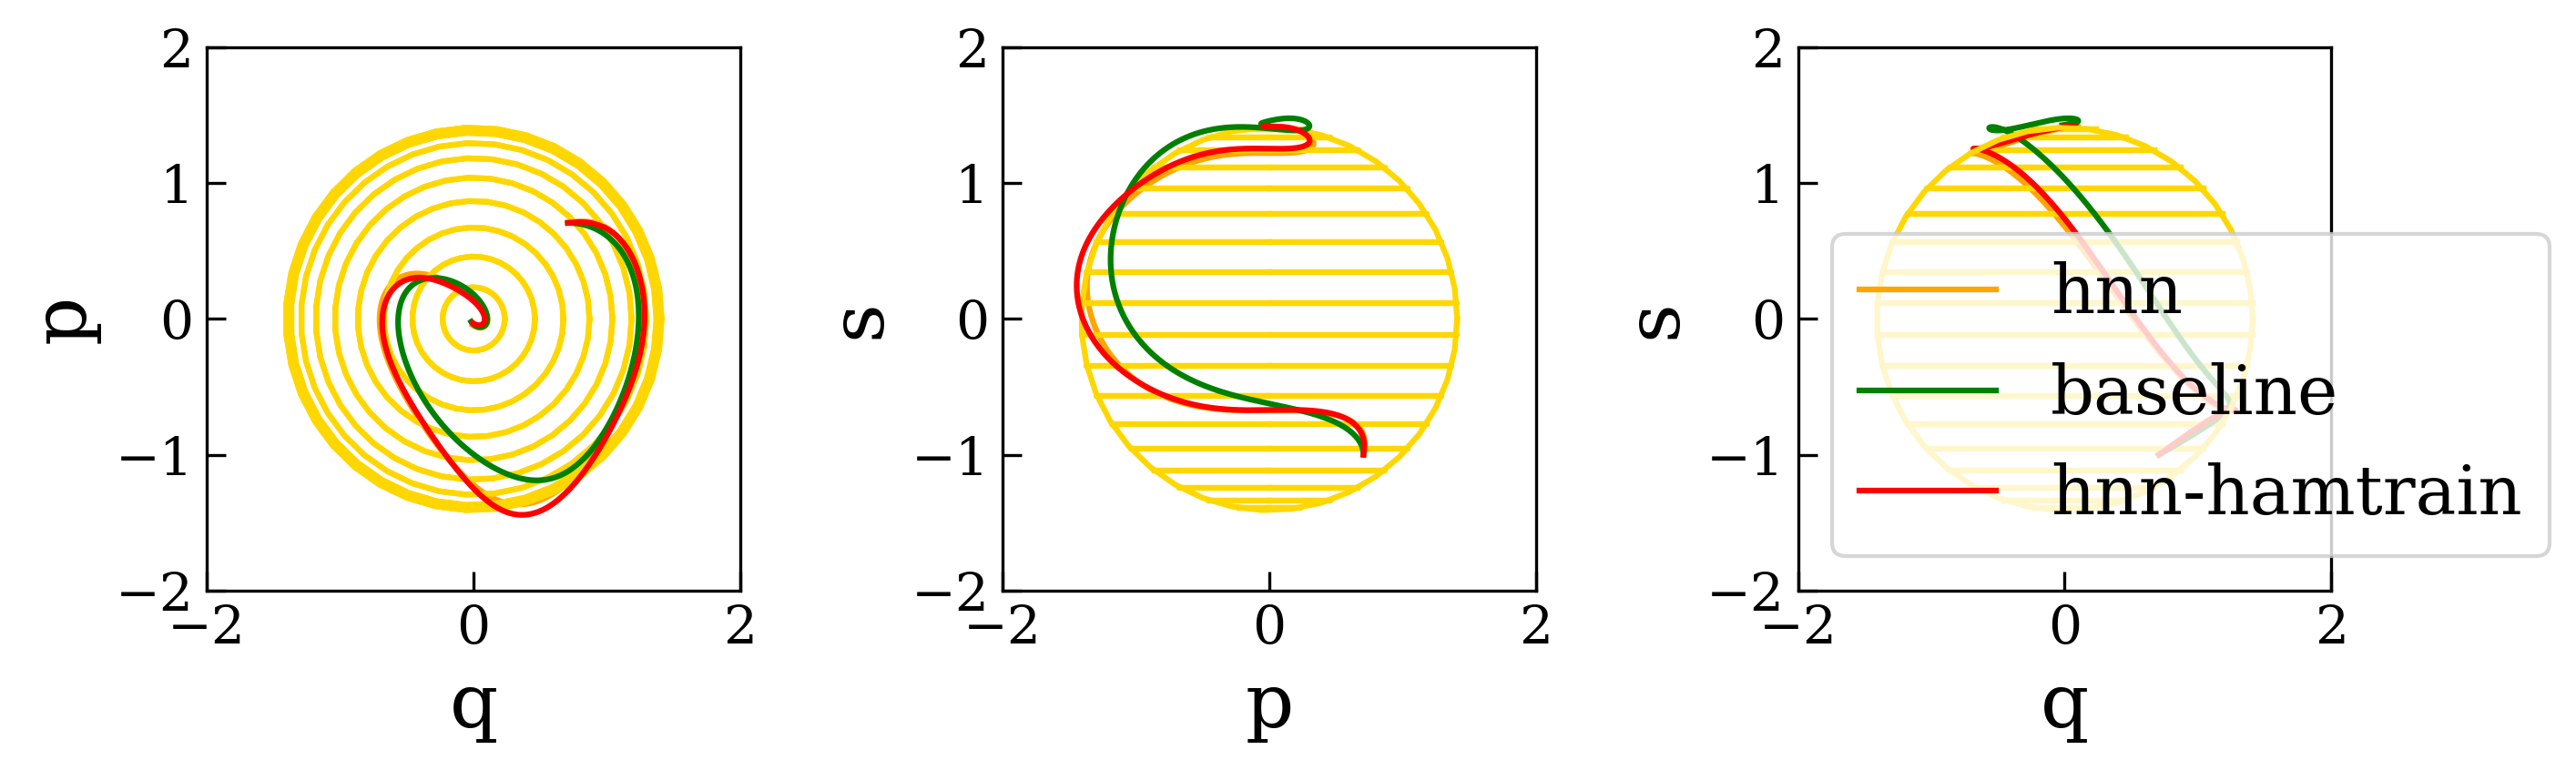

In [11]:
fig = plt.figure(figsize=(9.5,3.1), facecolor='white', dpi=DPI)
u, v = nump.mgrid[0 : 2 * np.pi : 40j, 0 : np.pi : 20j]
x2 = np.sqrt(2.) * np.cos(u) * np.sin(v)
y2 = np.sqrt(2.) * np.sin(u) * np.sin(v)
z2 = np.sqrt(2.) * np.cos(v)
ax1=fig.add_subplot(1, 3, 1,frameon=True)
ax2=fig.add_subplot(1, 3, 2,frameon=True)
ax3=fig.add_subplot(1, 3, 3,frameon=True)
ax1.plot(hnn_ivp['y'].T[:,0],hnn_ivp['y'].T[:,1],color='orange',label='hnn')
ax1.plot(x2,y2,color='gold')
ax1.plot(base_ivp['y'].T[:,0],base_ivp['y'].T[:,1],color='green',label='baseline')
ax1.plot(hnn_ivp_ht['y'].T[:,0],hnn_ivp_ht['y'].T[:,1],color='red',label='hnn-hamtrain')
ax1.set_xlabel('q')
ax1.set_ylabel('p',rotation=90)
ax1.set_xlim(-2,2)
ax1.set_ylim(-2,2)
ax2.plot(hnn_ivp['y'].T[:,1],hnn_ivp['y'].T[:,2],color='orange',label='hnn')
ax2.plot(y2,z2,color='gold')
ax2.plot(x2[:,10],y2[:,10],color='gold')
ax2.plot(base_ivp['y'].T[:,1],base_ivp['y'].T[:,2],color='green',label='baseline')
ax2.plot(hnn_ivp_ht['y'].T[:,1],hnn_ivp_ht['y'].T[:,2],color='red',label='hnn-hamtrain')
ax2.set_xlabel('p')
ax2.set_ylabel('s',rotation=90)
ax2.set_xlim(-2,2)
ax2.set_ylim(-2,2)
ax3.plot(hnn_ivp['y'].T[:,0],hnn_ivp['y'].T[:,2],color='orange',label='hnn')
ax3.plot(x2,z2,color='gold')
ax3.plot(base_ivp['y'].T[:,0],base_ivp['y'].T[:,2],color='green',label='baseline')
ax3.plot(hnn_ivp_ht['y'].T[:,0],hnn_ivp_ht['y'].T[:,2],color='red',label='hnn-hamtrain')
ax3.plot(x2[:,10],y2[:,10],color='gold')
ax3.set_xlabel('q')
ax3.set_ylabel('s',rotation=90)
ax3.set_xlim(-2,2)
ax3.set_ylim(-2,2)
ax3.legend()
plt.tight_layout(); plt.show()

## Quantitative analysis
* Choose trajectories from the test set
* Measure vector field loss at each point
* Integrate along trajectory and measure mean loss between points

In [12]:
def integrate_models(x0=np.array([sq2/2,sq2/2,.0]), t_span=[0,10], t_eval=None, noise_std=0.1):
    # integrate along ground truth vector field
    kwargs = {'t_eval': t_eval, 'rtol': 1e-12}
    true_path = solve_ivp(fun=dynamics_fn, t_span=t_span, y0=x0, **kwargs)
    true_x = true_path['y'].T
    
    # rescale time to compensate for noise effects, as described in appendix
    t_span[1] *= 1 + .9*noise_std
    t_eval *= 1 + .9*noise_std

    # integrate along baseline vector field
    base_path = integrate_model(base_model, t_span, x0, **kwargs)
    base_x = base_path['y'].T
    _tmp = torch.tensor( true_x, requires_grad=True, dtype=torch.float32)

    # integrate along HNN vector field
    hnn_path = integrate_model(hnn_model, t_span, x0, **kwargs)
    hnn_x = hnn_path['y'].T
    _tmp = torch.tensor( true_x, requires_grad=True, dtype=torch.float32)
    
    # integrate along HNN vector field
    hnn_path_ht = integrate_model(hnn_model_ht, t_span, x0, **kwargs)
    hnn_x_ht = hnn_path_ht['y'].T
    _tmp = torch.tensor( true_x, requires_grad=True, dtype=torch.float32)
    return true_x, base_x, hnn_x, hnn_x_ht

def energy_loss(true_x, integrated_x):
    true_energy = (true_x**2).sum(1)
    integration_energy = (integrated_x**2).sum(1)
    return np.mean((true_energy - integration_energy)**2)

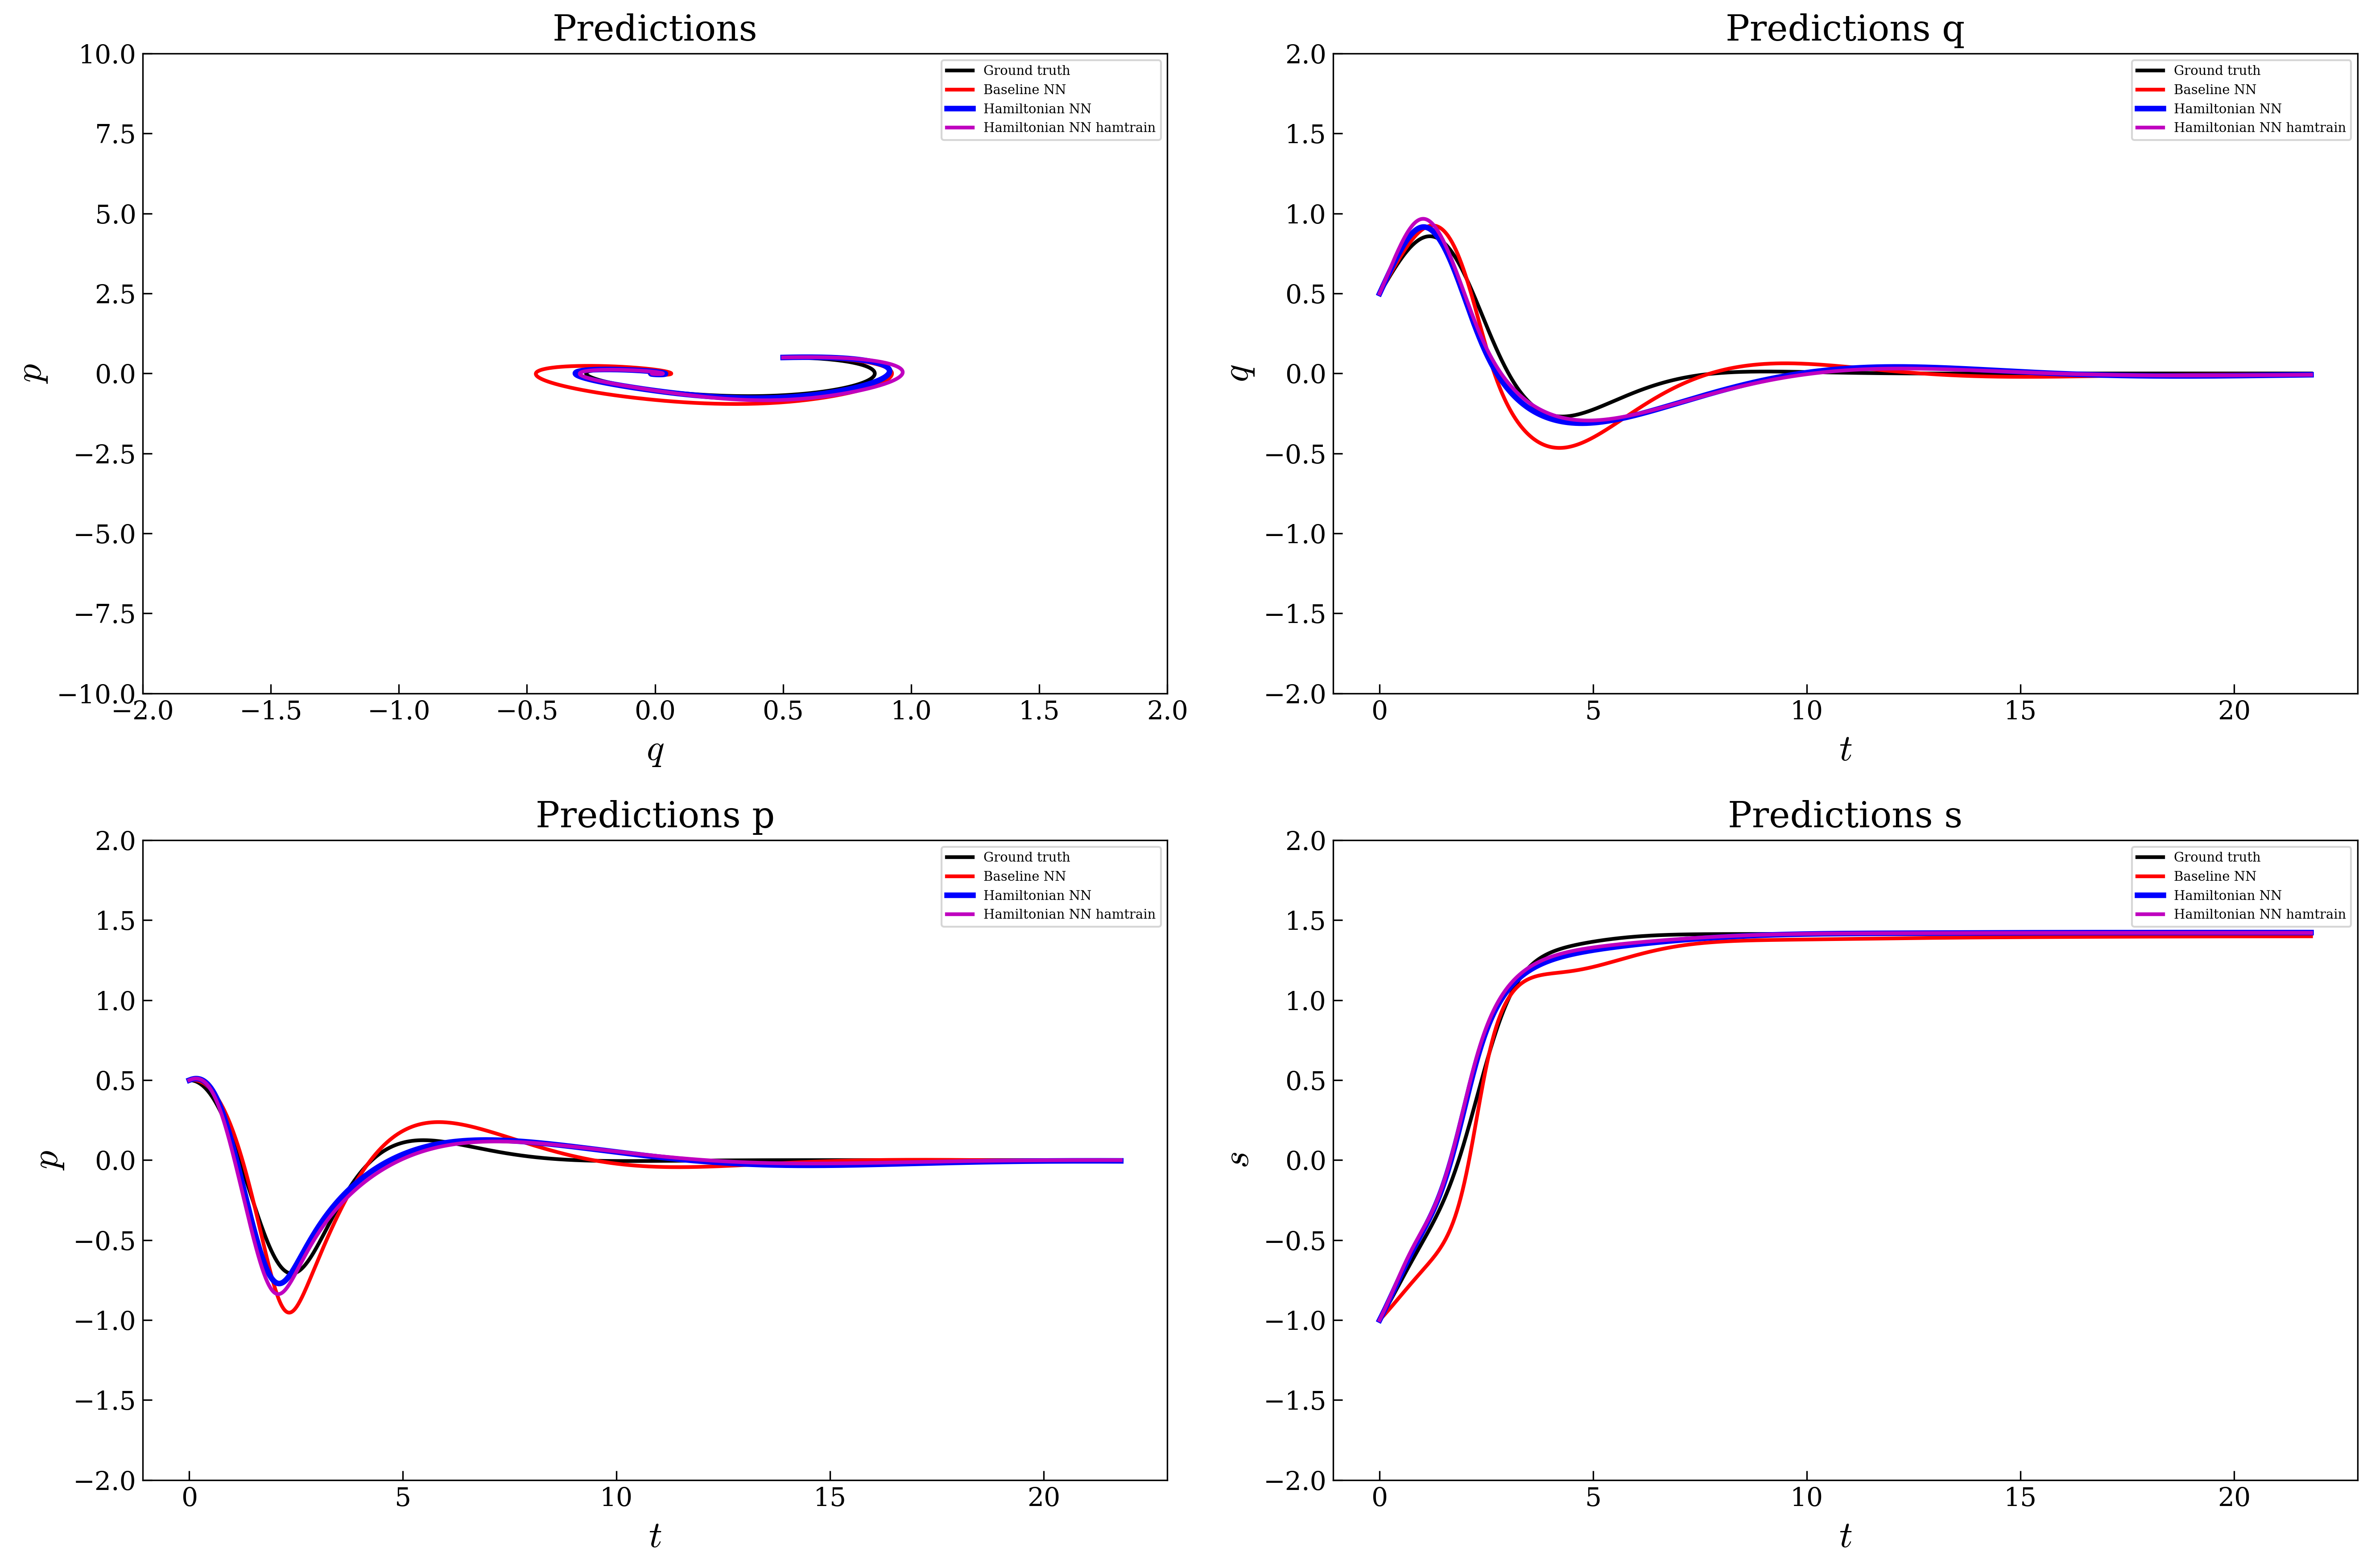

In [13]:
#spans=np.arange(8.5, 9.5,0.5)
spans=[9.]
fig = plt.figure(figsize=[18,12], dpi=DPI)
t_span=[0,20]
t_eval = np.linspace(t_span[0], t_span[1], 1000)
ax1=plt.subplot(2,2,1)
ax2=plt.subplot(2,2,2)
ax3=plt.subplot(2,2,3)
ax4=plt.subplot(2,2,4)
#ax5=plt.subplot(2,4,5)
#ax6=plt.subplot(2,4,6)
#ax7=plt.subplot(2,4,7)
#ax8=plt.subplot(2,4,8)

for sigma in spans:
    x0=np.array([0.5,0.5,-1.])
    #x0*=sigma/(np.linalg.norm(x0,2))


    # integration
    true_x, base_x, hnn_x, hnn_x_ht= integrate_models(x0=x0, t_span=t_span, t_eval=t_eval)

    # plotting
    tpad = 7
    ax1.set_title("Predictions", pad=tpad); ax1.set_xlabel('$q$') ; ax1.set_ylabel('$p$')
    ax1.plot(true_x[:,0], true_x[:,1], 'k-', label='Ground truth', linewidth=2)
    ax1.plot(base_x[:,0], base_x[:,1], 'r-', label='Baseline NN', linewidth=2)
    ax1.plot(hnn_x[:,0], hnn_x[:,1], 'b-', label='Hamiltonian NN', linewidth=3)
    ax1.plot(hnn_x_ht[:,0], hnn_x_ht[:,1], 'm-', label='Hamiltonian NN hamtrain', linewidth=2)
    ax1.set_xlim(-2,2) ; ax1.set_ylim(-10,10)
    ax1.legend(fontsize=7)

    ax2.set_title("Predictions q", pad=tpad) ; ax2.set_xlabel('$t$') ; ax2.set_ylabel('$q$')
    ax2.plot(t_eval, true_x[:,0], 'k-', label='Ground truth', linewidth=2)
    ax2.plot(t_eval, base_x[:,0], 'r-', label='Baseline NN', linewidth=2)
    ax2.plot(t_eval, hnn_x[:,0], 'b-', label='Hamiltonian NN', linewidth=3)
    ax2.plot(t_eval, hnn_x_ht[:,0], 'm-', label='Hamiltonian NN hamtrain', linewidth=2)
    ax2.set_ylim(-2,2)
    ax2.legend(fontsize=7)  
    
    ax3.set_title("Predictions p", pad=tpad) ; ax3.set_xlabel('$t$') ; ax3.set_ylabel('$p$')
    ax3.plot(t_eval, true_x[:,1], 'k-', label='Ground truth', linewidth=2)
    ax3.plot(t_eval, base_x[:,1], 'r-', label='Baseline NN', linewidth=2)
    ax3.plot(t_eval, hnn_x[:,1], 'b-', label='Hamiltonian NN', linewidth=3)
    ax3.plot(t_eval, hnn_x_ht[:,1], 'm-', label='Hamiltonian NN hamtrain', linewidth=2)
    ax3.set_ylim(-2,2)
    ax3.legend(fontsize=7)
    
    ax4.set_title("Predictions s", pad=tpad) ; ax4.set_xlabel('$t$') ; ax4.set_ylabel('$s$')
    ax4.plot(t_eval, true_x[:,2], 'k-', label='Ground truth', linewidth=2)
    ax4.plot(t_eval, base_x[:,2], 'r-', label='Baseline NN', linewidth=2)
    ax4.plot(t_eval, hnn_x[:,2], 'b-', label='Hamiltonian NN', linewidth=3)
    ax4.plot(t_eval, hnn_x_ht[:,2], 'm-', label='Hamiltonian NN hamtrain', linewidth=2)
    ax4.set_ylim(-2,2)
    ax4.legend(fontsize=7)
    
    #ax5.set_title("MSE between coordinates", pad=tpad) ; ax5.set_xlabel('Time step')
    #ax5.plot(t_eval, ((true_x-base_x)**2).mean(-1), 'r-', label='Baseline NN', linewidth=2)
    #ax5.plot(t_eval, ((true_x-hnn_x)**2).mean(-1), 'b-', label='Hamiltonian NN', linewidth=2)
    #ax5.plot(t_eval, ((true_x-hnn_x_ht)**2).mean(-1), 'm-', label='Hamiltonian NN hamtrain', linewidth=2)
    #ax5.legend(fontsize=7)

    #ax6.set_title("Total HNN-energy", pad=tpad)
    #ax6.set_xlabel('t')
    #true_hq = hnn_model(torch.Tensor(true_x))[1].detach().numpy().squeeze()
    #true_hq = np.stack([hamiltonian_fn(c) for c in true_x]).squeeze()
    #base_hq = hnn_model(torch.Tensor(base_x))[1].detach().numpy().squeeze()
    #hnn_hq = hnn_model(torch.Tensor(hnn_x))[1].detach().numpy().squeeze()
    #hnn_hq_ht = hnn_model_ht(torch.Tensor(hnn_x_ht))[1].detach().numpy().squeeze()
    #ax6.plot(t_eval, true_hq, 'k-', label='Ground truth', linewidth=2)
    #ax6.plot(t_eval, base_hq, 'r-', label='Baseline NN', linewidth=2)
    #ax6.plot(t_eval, hnn_hq, 'b-', label='Hamiltonian NN', linewidth=2)
    #ax6.plot(t_eval, hnn_hq_ht, 'm-', label='Hamiltonian NN hamtrain', linewidth=2)
    #ax6.legend(fontsize=7)

    #ax7.set_title("Hamiltonian", pad=tpad)
    #ax7.set_xlabel('t')
    #ax7.plot(t_eval, 0, 'k-', label='Ground truth', linewidth=2)
    #ax7.plot(t_eval, np.abs(true_hq-base_hq), 'r-', label='Baseline NN', linewidth=2)
    #ax7.plot(t_eval, np.abs(true_hq-hnn_hq), 'b-', label='Hamiltonian NN', linewidth=2)
    #ax7.plot(t_eval, np.abs(true_hq-hnn_hq_ht), 'm-', label='Hamiltonian NN hamtrain', linewidth=2)
    #ax7.legend(fontsize=7)
    
    #ax8.set_title("Error Constant of Motion", pad=tpad) ; ax8.set_xlabel('Time step')
    #true_e = np.stack([k2_fn(c) for c in true_x])
    #base_e = np.stack([k2_fn(c) for c in base_x])
    #hnn_e = np.stack([k2_fn(c) for c in hnn_x])
    #ax8.plot(t_eval, true_e, 'k-', label='Ground truth', linewidth=2)
    #ax8.plot(t_eval, base_e, 'r-', label='Baseline NN', linewidth=2)
    #ax8.plot(t_eval, hnn_e, 'b-', label='Hamiltonian NN', linewidth=2)
    #ax8.legend(fontsize=7)

plt.tight_layout()
plt.show()
#fig.savefig('{}/quad-osc{}.{}'.format(args.fig_dir, RK4, FORMAT))

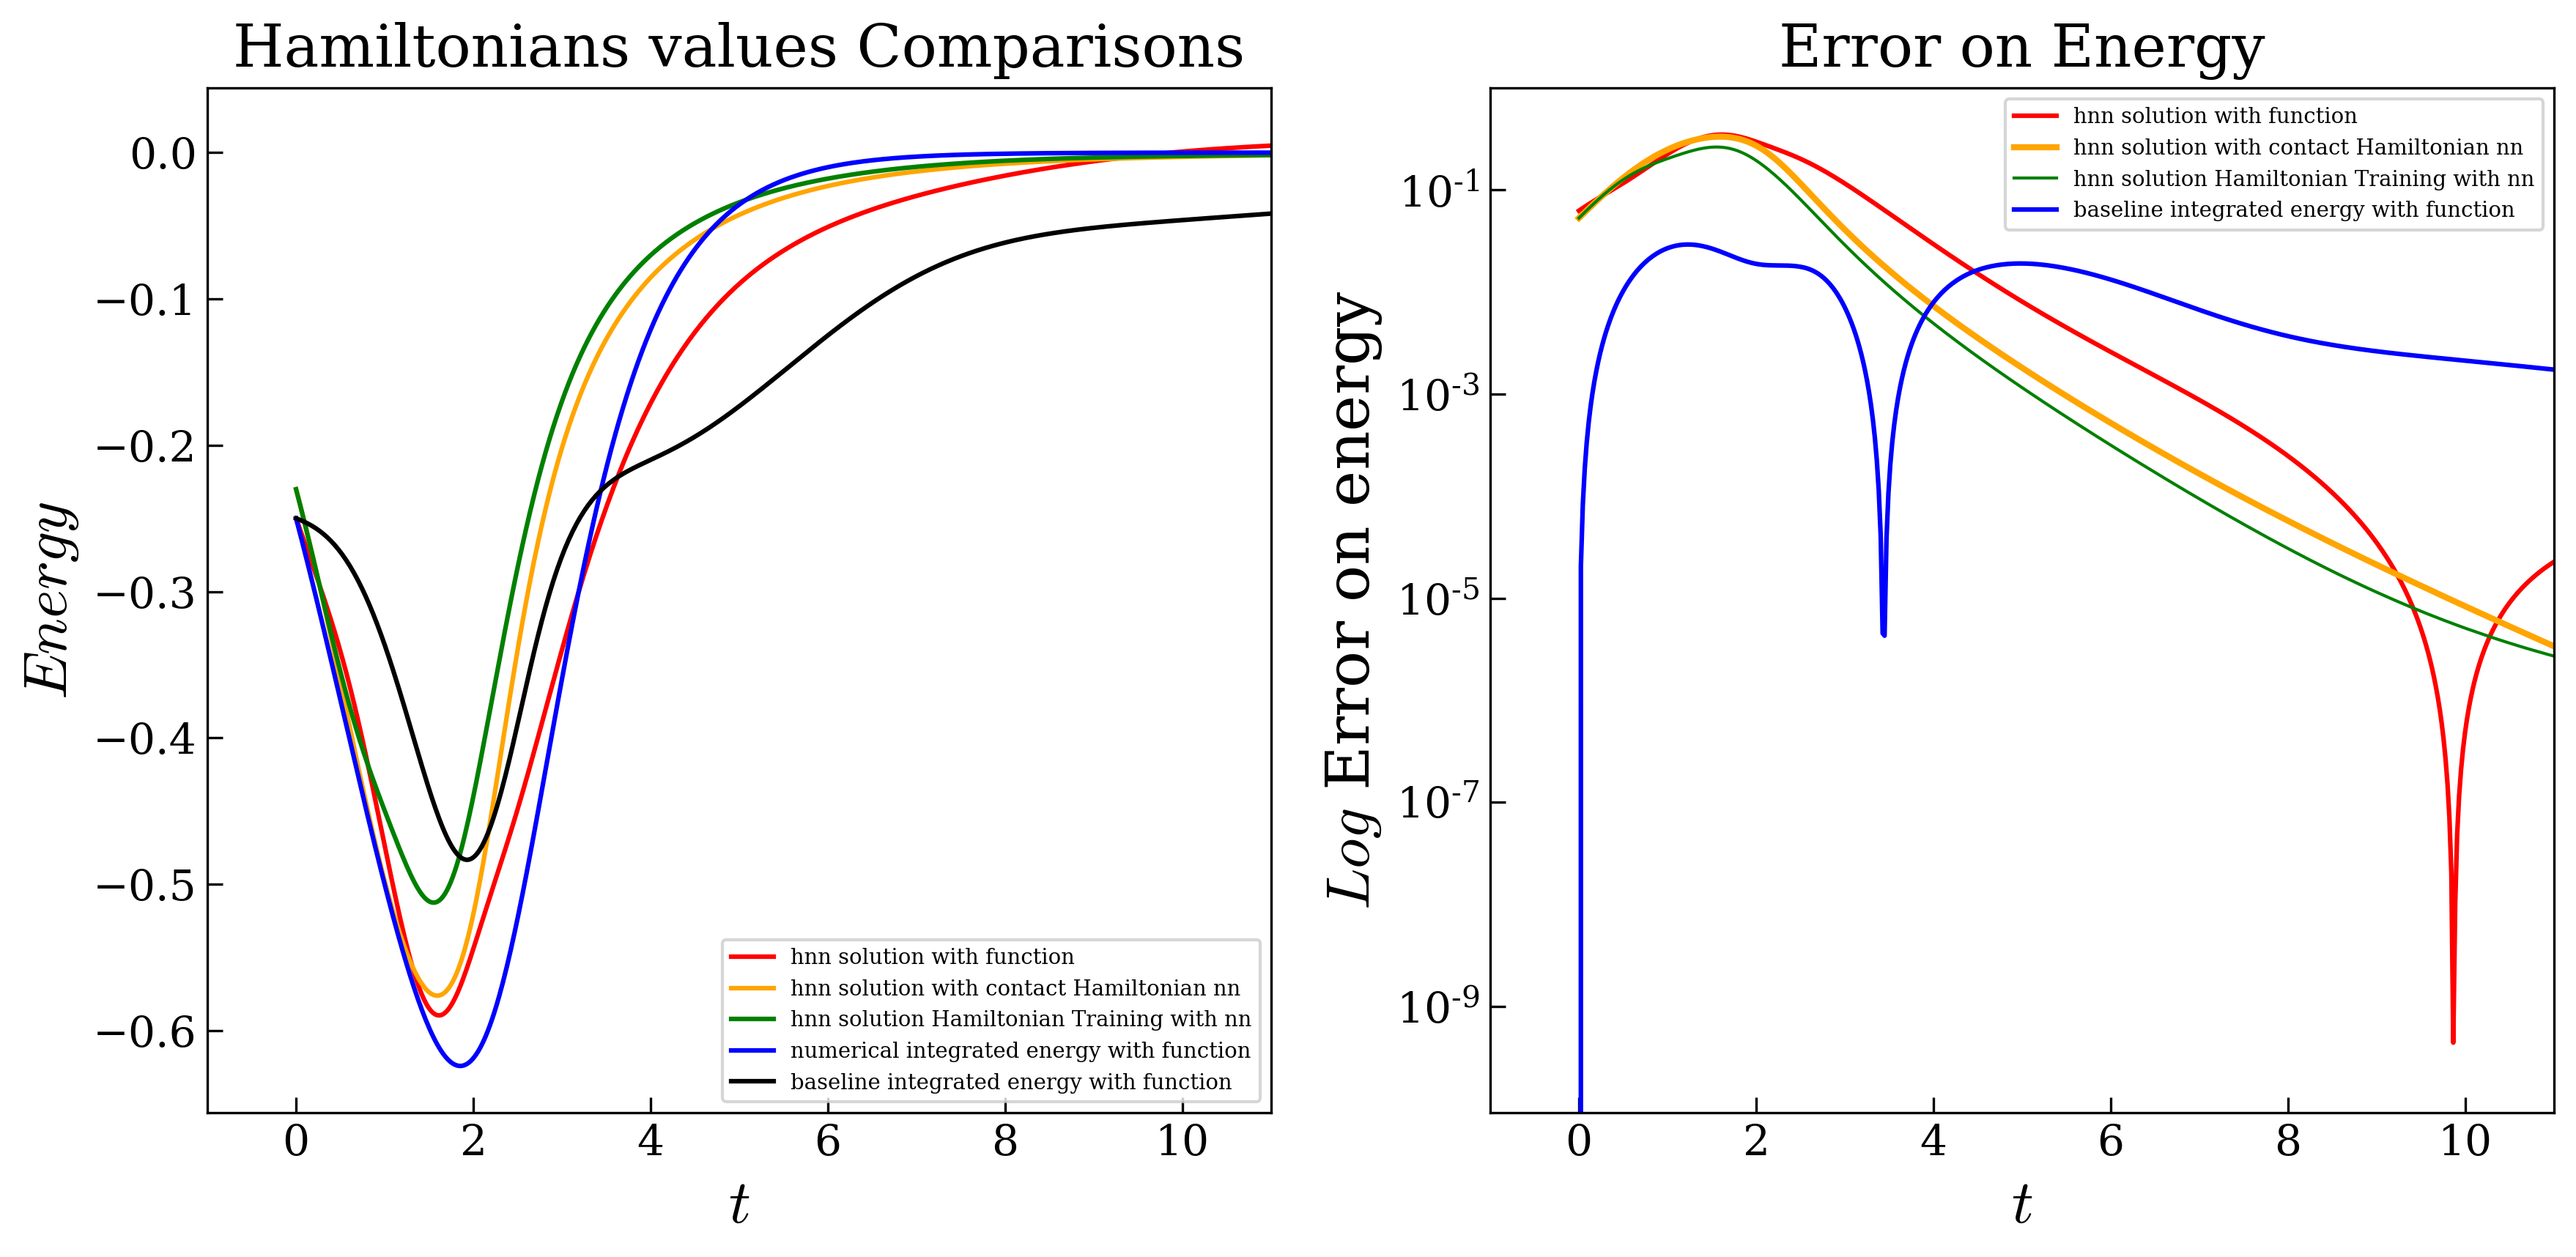

In [14]:
fig = plt.figure(figsize=[12,6], dpi=DPI)
plt.subplot(1,2,1)
tpad=7
plt.title("Hamiltonians values Comparisons", pad=tpad) ; plt.xlabel('$t$') ; plt.ylabel('$Energy$')
#h0=hamiltonian_fn(x0)
#real_hq = np.stack([h0*np.exp(-t/4.) for t in t_eval]).squeeze()
hnn_hq = hnn_model(torch.Tensor(hnn_x))[1].detach().numpy().squeeze()
hnn_hq1 = np.stack([hamiltonian_fn(c) for c in hnn_x]).squeeze()
true_hq = np.stack([hamiltonian_fn(c) for c in true_x]).squeeze()
base_hq = np.stack([hamiltonian_fn(c) for c in base_x]).squeeze()
hnn_hq_ht = hnn_model(torch.Tensor(hnn_x_ht))[1].detach().numpy().squeeze()
#base_hq1 = contact_baseline_energy(base_x).squeeze()
plt.plot(t_eval, hnn_hq1,label='hnn solution with function',color='red')
plt.plot(t_eval,hnn_hq,label='hnn solution with contact Hamiltonian nn',color='orange')
plt.plot(t_eval, hnn_hq_ht, label='hnn solution Hamiltonian Training with nn',color='green')
plt.plot(t_eval, true_hq, label='numerical integrated energy with function',color='blue')
plt.plot(t_eval, base_hq, label='baseline integrated energy with function',color='black')
#plt.plot(t_eval, base_hq1, label='baseline integrated energy with contraction')
#plt.plot(t_eval, real_hq, label='real contact energy flow')
plt.xlim(-1,11)
plt.legend(fontsize=7)

plt.subplot(1,2,2)
plt.title("Error on Energy", pad=tpad); plt.xlabel('$t$') ; plt.ylabel('$Log$ Error on energy')
dhnn_hq1=(hnn_hq1)**2
dhnn_hq=(hnn_hq)**2
dhnn_hq_ht=(hnn_hq_ht)**2
#dtrue_hq=(real_hq-true_hq)**2
dbase_hq=(true_hq-base_hq)**2
#dbase_hq1=(real_hq-base_hq1)**2
plt.plot(t_eval, (dhnn_hq1),label='hnn solution with function',color='red')
plt.plot(t_eval, (dhnn_hq),label='hnn solution with contact Hamiltonian nn', linewidth=2, color='orange')
plt.plot(t_eval, (dhnn_hq_ht),label='hnn solution Hamiltonian Training with nn',linewidth=1,color='green')
#plt.plot(t_eval, (dtrue_hq), label='numerical integrated energy with function')
plt.plot(t_eval, (dbase_hq), label='baseline integrated energy with function',color='blue')
#plt.plot(t_eval, (dbase_hq1), label='baseline integrated energy with contraction')
plt.xlim(-1,11)
plt.yscale('log')
plt.legend(fontsize=7)

plt.tight_layout() ; plt.show()
#fig.savefig('{}/blank{}.{}'.format(args.fig_dir, RK4, FORMAT))

In [31]:
t_span=[0.,5.]
t_eval=np.linspace(t_span[0], t_span[1], num=100)
basem=None
hnnm=None
hnn_htm=None
fig = plt.figure(figsize=[12,6], dpi=DPI)
samples=30
for i in range(samples):
    y0=None
    radius=None
    if y0 is None:
        theta0 =(np.random.rand()+0.1)*2*np.pi
        phi0 = (np.random.rand()+0.1)*np.pi
        y0=np.array([np.cos(theta0)*np.sin(phi0),np.sin(theta0)*np.sin(phi0),np.cos(phi0)])
    if radius is None:
        radius = 2.*np.random.rand() + 0.1 # sample a range of radii
    y0 *= radius/np.linalg.norm(y0,2)
    true_x, base_x, hnn_x, hnn_x_ht= integrate_models(x0=y0, t_span=t_span, t_eval=t_eval)
    basem=+((((true_x-base_x)**2).mean(-1))/30)
    hnnm=+ ((((true_x-hnn_x)**2).mean(-1))/30)
    hnn_htm=+((((true_x-hnn_x_ht)**2).mean(-1))/30)
    
#ax5.set_title("MSE between coordinates", pad=tpad) ; ax5.set_xlabel('t')

<Figure size 3600x1800 with 0 Axes>

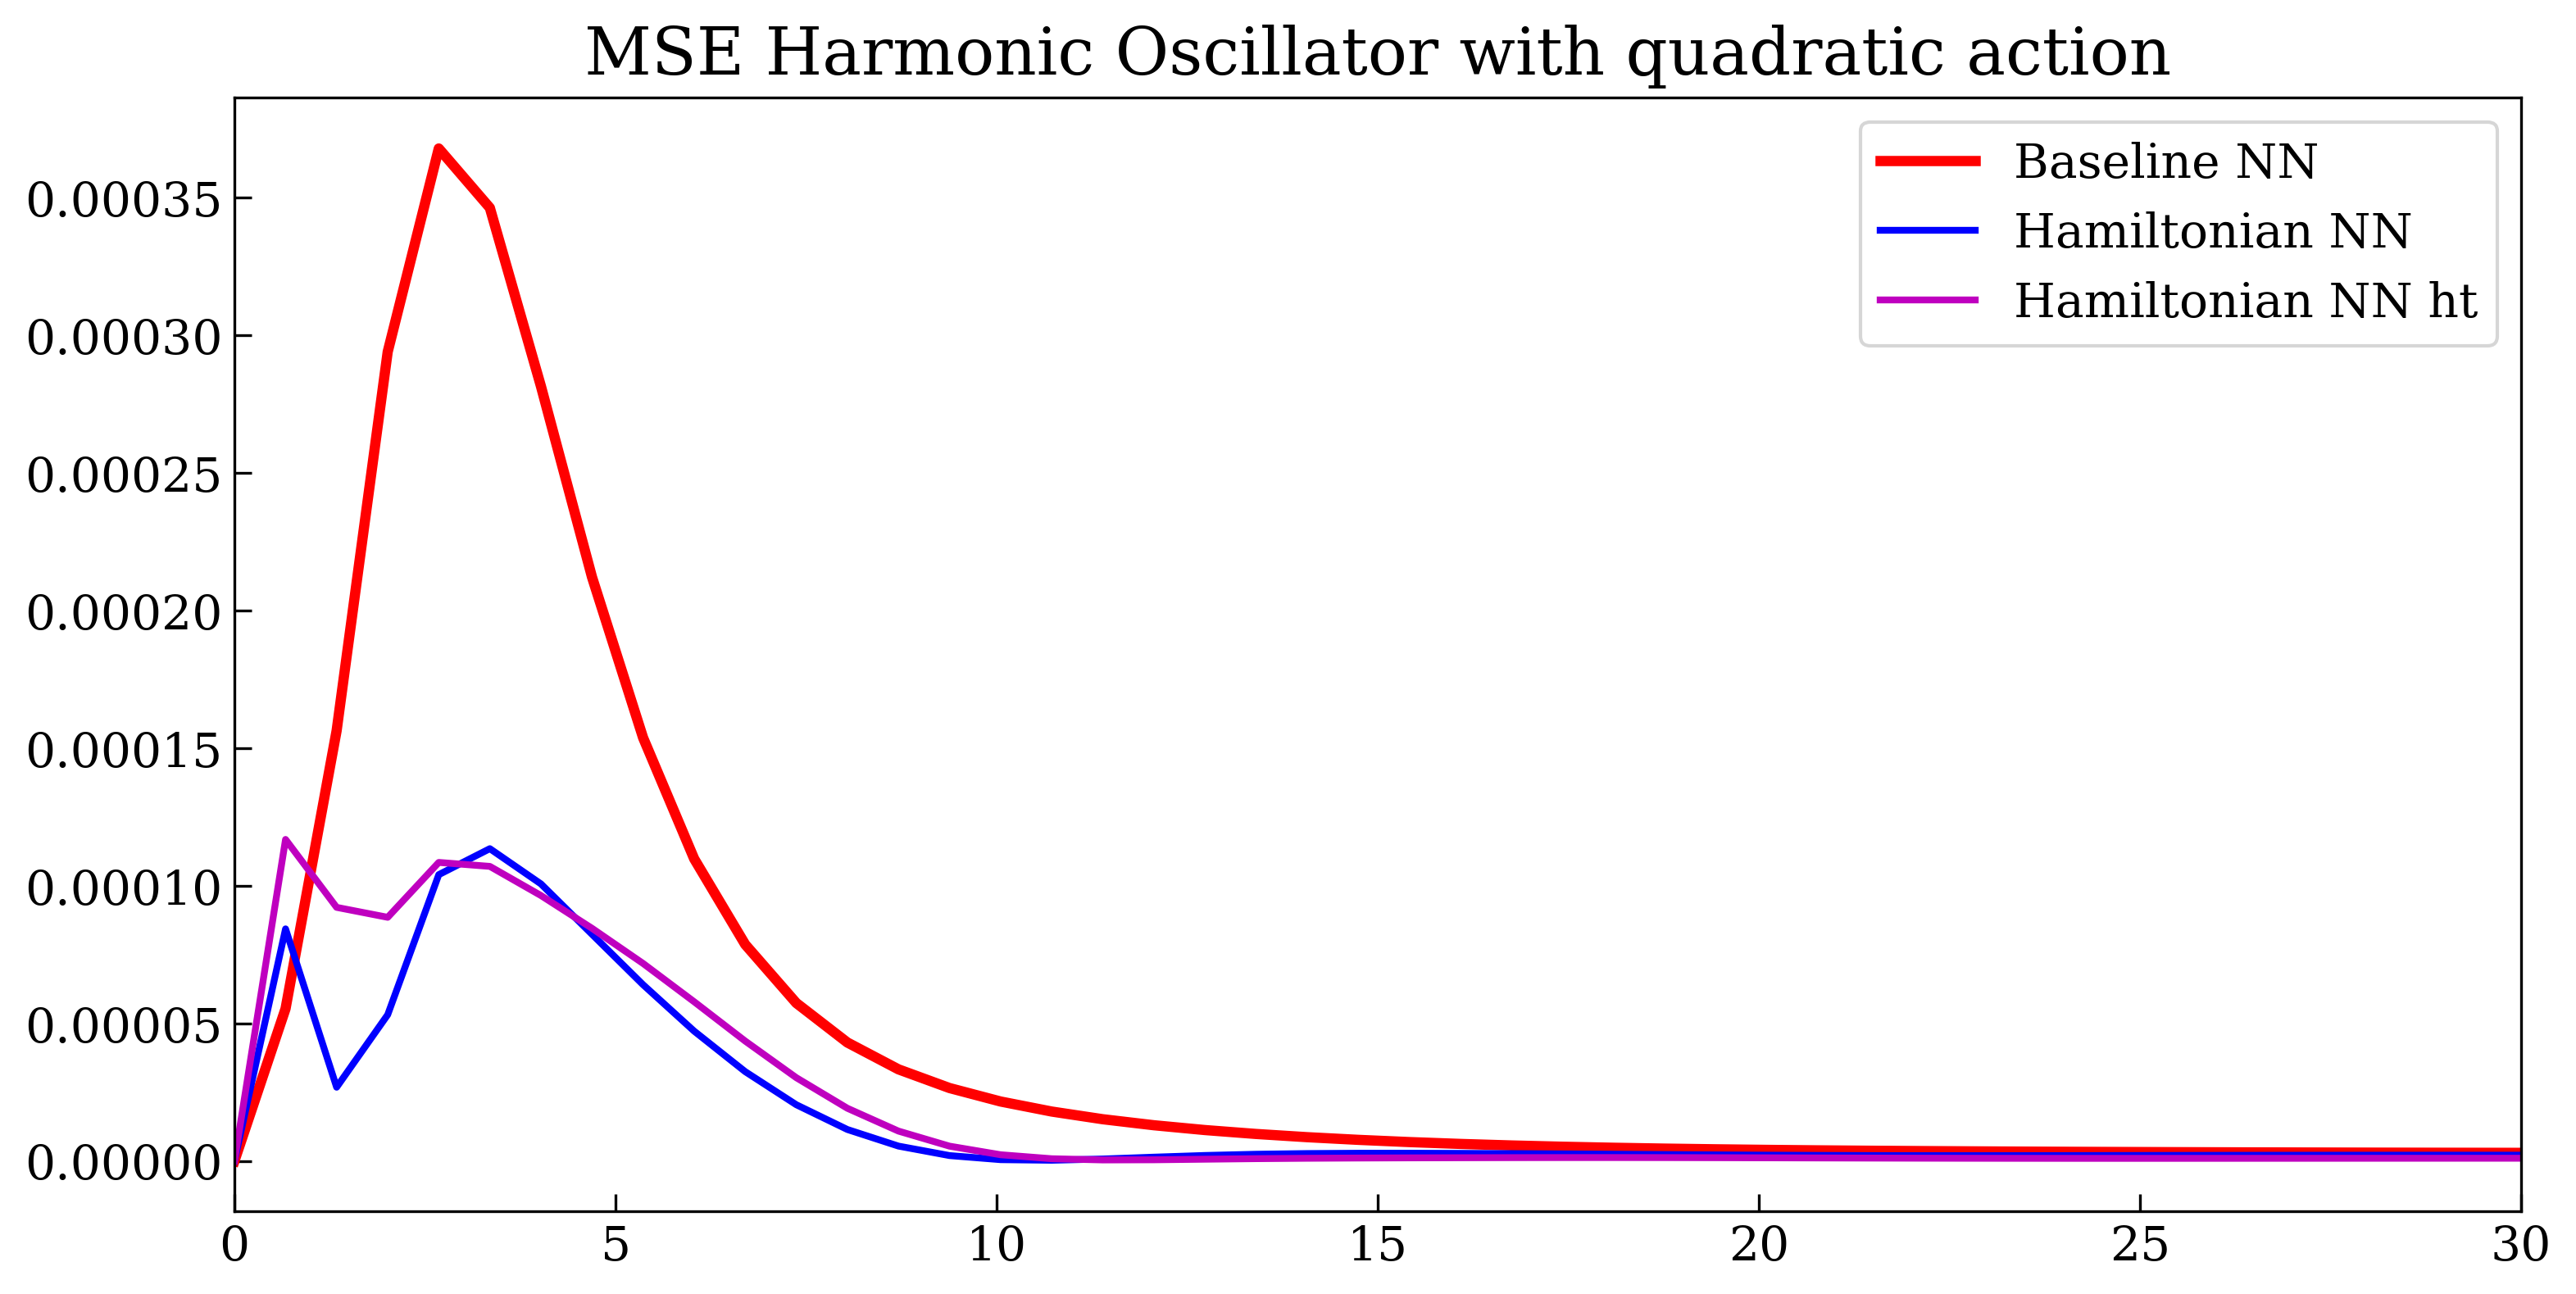

In [37]:
basem.shape
t_eval.shape
fig = plt.figure(figsize=[12,6], dpi=DPI)
plt.plot(t_eval, basem, 'r-', label='Baseline NN', linewidth=3)
plt.plot(t_eval, hnnm, 'b-', label='Hamiltonian NN', linewidth=2)
plt.plot(t_eval, hnn_htm, 'm-', label='Hamiltonian NN ht', linewidth=2)
plt.title("MSE Harmonic Oscillator with quadratic action", pad=tpad)
plt.legend(fontsize=14)
plt.xlim([0,30])
plt.show()

In [38]:
fig.savefig('{}/quadosc-integrationquadosc{}.{}'.format(args.fig_dir, RK4, FORMAT))